# OYAYE - Dataset Generation

## TODO: Improve this description

This is notebook generates the dataset to be used in the training of Spiking Neural Networks. 

This notebook uses the orekit python wrapper. In this stage a KeplerianPropagator was used for simplicity;
in the future, it should be replaced with a numericalPropagator with a NumericalIntegrator (Dormand-Prince) and a DragForce,
ThirdBodyAttraction, and SolarRadiationPressure from Orekit.

Projecting to the sensor/image plane and producing frames (for real conversion to DVS) will require a rendering pipeline (SPIN/PANGU/Simus)
or image generation via offscreen OpenGL; here, I've included a heuristic converter that generates events based on angular variation—sufficient for the initial POC.

To generate real images (frames) and then convert them to events with ESIM, you can render the satellite as a sprite
on a stellar background (with Celestia, Blender, or SPIN) and apply a frame-to-event converter.

In [48]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (necessary for 3D plots)
from matplotlib import animation
from IPython.display import Video

import orekit
from orekit.pyhelpers import setup_orekit_curdir
from org.orekit.time import AbsoluteDate, TimeScalesFactory
from org.orekit.frames import FramesFactory
from org.orekit.orbits import KeplerianOrbit, PositionAngle
from org.orekit.propagation.analytical import KeplerianPropagator
from org.orekit.bodies import OneAxisEllipsoid
from org.orekit.utils import Constants, PVCoordinates
from org.orekit.propagation.events import ElevationDetector
from org.orekit.models.earth import ReferenceEllipsoid
from org.orekit.bodies import GeodeticPoint
from org.orekit.frames import TopocentricFrame
from org.orekit.orbits import CartesianOrbit, OrbitType
from org.hipparchus.geometry.euclidean.threed import Vector3D  

print('Python version:', end=' ')
print(sys.version.split('\n')[0])


Python version: 3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]


## Initialization

The first thing to be done is to set the global variables that will hold constants, such as Earth's gravity. Make sure to have "orekit-data.zip" downloaded from the Orekit website if it is not available

In [17]:
orekit.initVM()
setup_orekit_curdir("data/orekit-data.zip")

MU = Constants.EIGEN5C_EARTH_MU #gravidade
FRAME = FramesFactory.getGCRF()
UTC = TimeScalesFactory.getUTC() #Timescale
EPOCH = AbsoluteDate(2025, 10, 1, 0, 0, 0.0, UTC)  # Epoch date

print(f"MU = {MU} \nFrame = {FRAME} \nUTC = {UTC}\nEpoch = {EPOCH}")

MU = 398600441500000.0 
Frame = GCRF 
UTC = UTC
Epoch = 2025-10-01T00:00:00.000Z


Since we are talking about debris, we need to also set up the basic orbital elements.

In [18]:
a = Constants.WGS84_EARTH_EQUATORIAL_RADIUS + 700000.0 #semi-eixo maior
e = 0.001
i = float(np.deg2rad(51.6))
raan = float(np.deg2rad(120.0)) # right ascension of ascending node
argp = float(np.deg2rad(45.0)) # perigee argument
M0 = float(np.deg2rad(0.0)) # mean anomaly

print(f"Semi-major axis (a) = {a} m\n"
      f"Eccentricity (e) = {e}\n"
      f"Inclination (i) = {i} degrees\n"
      f"Right Ascension of Ascending Node (RAAN) = {raan} degrees\n"
      f"Argument of Perigee (ω) = {argp} degrees\n"
      f"Mean Anomaly (M0) = {M0} degrees\n")

Semi-major axis (a) = 7078137.0 m
Eccentricity (e) = 0.001
Inclination (i) = 0.9005898940290741 degrees
Right Ascension of Ascending Node (RAAN) = 2.0943951023931953 degrees
Argument of Perigee (ω) = 0.7853981633974483 degrees
Mean Anomaly (M0) = 0.0 degrees



Now we can create an Orbit object and its propagator with these variables!

In [19]:
orbit = KeplerianOrbit(a, e, i, argp, raan, M0, PositionAngle.MEAN, FRAME, EPOCH, MU)
propagator = KeplerianPropagator(orbit)

print(orbit)

Keplerian parameters: {a: 7078137.0; e: 0.001; i: 51.6; pa: 45.0; raan: 119.99999999999999; v: 0.0;}


## Simulation

### 1. Single Object Orbit

Let's first simulate the orbit of a single the object

In [16]:
duration_sec = 3600 * 6 
dt = 10.0 

times = np.arange(0, duration_sec + dt, dt)
abs_dates = [EPOCH.shiftedBy(float(t)) for t in times]

positions = []
velocities = []
for ad in abs_dates:
    pv = propagator.getPVCoordinates(ad, FRAME)
    p = pv.getPosition()
    v = pv.getVelocity()
    positions.append([p.getX()/1000.0, p.getY()/1000.0, p.getZ()/1000.0])
    velocities.append([v.getX()/1000.0, v.getY()/1000.0, v.getZ()/1000.0])

Now, let's save the data so we can manipulate it later

In [20]:
df_pos = pd.DataFrame(positions, columns=["x_km", "y_km", "z_km"])
df_pos["tsec"] = times
df_pos.to_csv("data/positions_eci.csv", index=False)

In [21]:
df_pos.head()

,x_km,y_km,z_km,tsec
0,-5189.642218,2777.254053,3918.462328,0.0
1,-5191.364331,2714.601944,3959.867642,10.0
2,-5192.501167,2651.643790,4000.826519,20.0
3,-5193.052597,2588.386687,4041.334341,30.0
4,-5193.018560,2524.837769,4081.386541,40.0


### 2. Terrestrial Sensor
Awesome! Now that we have the first orbital data in hands, we can go ahead and simulate a terrestrial sensor to read angles from the object in orbit!

Let's set up some basic variables and constants first.

In [24]:
lat = float(np.deg2rad(-23.0))
lon = float(np.deg2rad(-43.0))
alt = 10.0
earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS,
                         Constants.WGS84_EARTH_FLATTENING,
                         FRAME)
gp = GeodeticPoint(lat, lon, alt)
topo = TopocentricFrame(earth, gp, "GS1")

print(f"Latitude (lat) = {lat} degrees\n"
      f"Longitude (lon) = {lon} degrees\n"
      f"Altitude (alt) = {alt} meters\n"
      f"Earth Model = {earth}\n"
      f"Flattening = {Constants.WGS84_EARTH_FLATTENING}\n"
      f"Equatorial Radius = {Constants.WGS84_EARTH_EQUATORIAL_RADIUS} meters\n"
      f"Geodetic Point = {gp}\n"
      f"Topocentric Frame Name = {topo}")

Latitude (lat) = -0.4014257279586958 degrees
Longitude (lon) = -0.7504915783575618 degrees
Altitude (alt) = 10.0 meters
Earth Model = org.orekit.bodies.OneAxisEllipsoid@4a6c0f38
Flattening = 0.0033528106647474805
Equatorial Radius = 6378137.0 meters
Geodetic Point = {lat: -23 deg, lon: -43 deg, alt: 10}
Topocentric Frame Name = GS1


Now it is time to simulate it!

In [25]:
obs_list = []
sigma_ang_deg = 0.001 #ruido para adicionar na medição

for t_idx, ad in enumerate(abs_dates):
    pv = propagator.getPVCoordinates(ad, FRAME)
    transform = FRAME.getTransformTo(topo.getParent(), ad) #simplificado, verificar depois
    try: 
        az = topo.getAzimuth(pv.getPosition(), FRAME, ad)
        el = topo.getElevation(pv.getPosition(), FRAME, ad)
    except Exception as e:
        az, el = None, None
    
    if el is not None and el > 0.0:
        # Adicona ruído gaussiano
        az_noisy = float(az) + np.deg2rad(np.random.normal(0, sigma_ang_deg))
        el_noisy = float(el) + np.deg2rad(np.random.normal(0, sigma_ang_deg))
        obs_list.append({"tsec": times[t_idx], "az_rad": az_noisy, "el_rad":el_noisy})


In [26]:
df_obs = pd.DataFrame(obs_list)
df_obs.to_csv("data/observation_angles.csv", index=False)

In [27]:
df_obs.head()

,tsec,az_rad,el_rad
0,2270.0,5.624241,0.008548
1,2280.0,5.626058,0.019459
2,2290.0,5.627946,0.030658
3,2300.0,5.629948,0.042138
4,2310.0,5.632003,0.053904


### 3. Fragments Generation and Observation

Great! Now we have all that we need to generate fragments and simulate their observation!

Let's use some python fanciness to create a function to make things more organized

In [30]:
def generate_fragments(base_orbit, N_frag=50, dv_sigma=1.0):
    frags = []
    for k in range(N_frag):
        dv = np.random.normal(0.0, dv_sigma, size=3)
        pv = propagator.getPVCoordinates(EPOCH,FRAME)
        p = pv.getPosition()
        v = pv.getVelocity()
        px,py,pz = p.getX(),p.getY(),p.getZ()
        vx,vy,vz = v.getX(),v.getY(),v.getZ()
        vx_new = float(vx + dv[0])
        vy_new = float(vy + dv[1])
        vz_new = float(vz + dv[2])
        pv_coordinates = PVCoordinates(Vector3D(px, py, pz), Vector3D(vx_new,vy_new,vz_new))
        new_orbit = CartesianOrbit(pv_coordinates,
                                   FRAME, EPOCH, MU)
        frags.append(new_orbit)
    return frags

In [31]:
fragments = generate_fragments(orbit, N_frag=20, dv_sigma=0.5)

Now let's propagate them...

In [32]:
frag_positions = []
for frag in fragments:
    prop = KeplerianPropagator(frag)
    poslist = []
    for ad in abs_dates:
        pv = prop.getPVCoordinates(ad, FRAME)
        p = pv.getPosition()
        poslist.append([p.getX()/1000.0, p.getY()/1000.0, p.getZ()/1000.0])
    frag_positions.append(np.array(poslist))


... and save their positions.

In [33]:
for idx, arr in enumerate(frag_positions):
    df = pd.DataFrame(arr, columns=["x_km", "y_km", "z_km"])
    df["tsec"] = times
    df.to_csv(f"data/fragments/fragment_{idx:02d}_positions.csv", index=False)

### TODO: GENERATE OBSERVATION FROM EARTH SENSOR

## Orbit Visualization

Let's visualize the simulated orbits and observations now and properly export the data to the rest of our pipeline for training the spiking neural networks.

### 1. Loading Files

To keep things simple, we are going to visualize solely the first orbit example that we simulated. You can change this as you wish.

In [71]:
pos_file = 'data/positions_eci.csv'

print('\nExpected files:')
print(' - positions CSV ->', pos_file)
print("\nChecking for file's existence")
print(os.path.exists(pos_file))


Expected files:
 - positions CSV -> data/positions_eci.csv

Checking for file's existence
True


In [72]:
df = pd.read_csv(pos_file)
print('Lines:', len(df))
display(df.head())
print('\nStats (km):')
print(df[['x_km','y_km','z_km']].describe().round(3))


Lines: 2161


,x_km,y_km,z_km,tsec
0,-5189.642218,2777.254053,3918.462328,0.0
1,-5191.364331,2714.601944,3959.867642,10.0
2,-5192.501167,2651.643790,4000.826519,20.0
3,-5193.052597,2588.386687,4041.334341,30.0
4,-5193.018560,2524.837769,4081.386541,40.0



Stats (km):
           x_km      y_km      z_km
count  2161.000  2161.000  2161.000
mean    172.843  -513.564   135.121
std    3715.406  4496.322  3974.111
min   -5193.108 -6514.879 -5551.007
25%   -3566.570 -4913.473 -3871.132
50%     316.723  -909.389   253.477
75%    3927.013  3753.843  4174.158
max    5203.499  6509.309  5543.166


### 2. 3D Static Plot and Animation
Let's see how that looks as a simple plot...

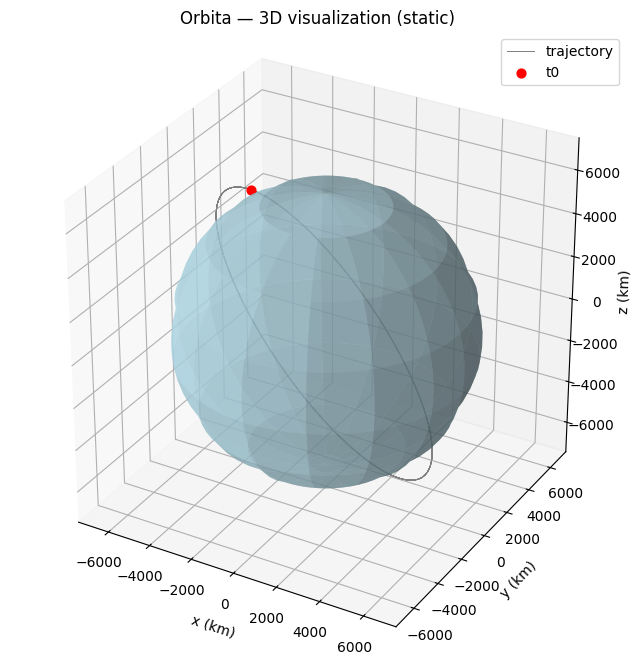

In [73]:
xs = df['x_km'].values
ys = df['y_km'].values
zs = df['z_km'].values

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1,1,1))

# Earth plot(sphere)
R_earth = 6371.0  # km (visual)
u = np.linspace(0, 2*np.pi, 60)
v = np.linspace(0, np.pi, 30)
xe = R_earth*np.outer(np.cos(u), np.sin(v))
ye = R_earth*np.outer(np.sin(u), np.sin(v))
ze = R_earth*np.outer(np.ones_like(u), np.cos(v))
ax.plot_surface(xe, ye, ze, rstride=4, cstride=4, color='lightblue', alpha=0.6, linewidth=0)

# Plot orbit trace
ax.plot(xs, ys, zs, lw=0.7, color='gray', label='trajectory')
ax.scatter([xs[0]],[ys[0]],[zs[0]], color='red', s=40, label='t0')

lim = np.max(np.abs(np.concatenate([xs, ys, zs]))) * 1.1
ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim); ax.set_zlim(-lim, lim)
ax.set_xlabel('x (km)'); ax.set_ylabel('y (km)'); ax.set_zlabel('z (km)')
ax.set_title('Orbita — 3D visualization (static)')
ax.legend()
plt.show()


That looks pretty neat! But can we animate it? Let's see...

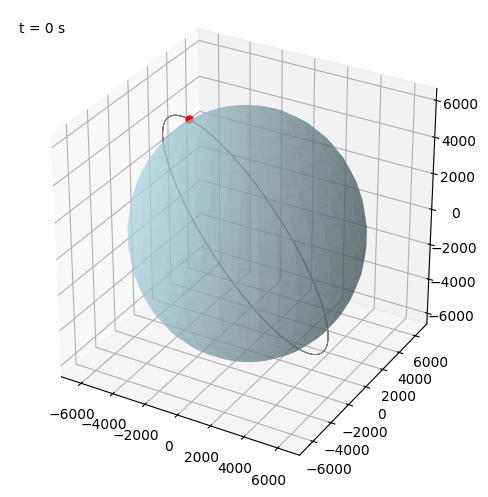

In [56]:
xs = df['x_km'].values
ys = df['y_km'].values
zs = df['z_km'].values
times = df['tsec'].values.astype(float)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1,1,1))

# draw earth (simplified)
R_earth = 6371.0
u = np.linspace(0, 2*np.pi, 40)
v = np.linspace(0, np.pi, 20)
xe = R_earth*np.outer(np.cos(u), np.sin(v))
ye = R_earth*np.outer(np.sin(u), np.sin(v))
ze = R_earth*np.outer(np.ones_like(u), np.cos(v))
ax.plot_surface(xe, ye, ze, color='lightblue', alpha=0.5, linewidth=0)

ax.plot(xs, ys, zs, lw=0.6, color='gray')
point, = ax.plot([xs[0]], [ys[0]], [zs[0]], marker='o', color='red', markersize=5)
time_text = ax.text2D(0.02, 0.95, "", transform=ax.transAxes)

def update(frame):
    point.set_data([xs[frame]], [ys[frame]])
    point.set_3d_properties([zs[frame]])
    time_text.set_text(f"t = {times[frame]:.0f} s")
    return point, time_text

ani = animation.FuncAnimation(fig, update, frames=len(xs), interval=5, blit=False)


In [57]:
out_file = 'data/orbit_animation.mp4'

In [ ]:
try:
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=20, metadata=dict(artist='Oyaye'), bitrate=4000)
    ani.save(out_file, writer=writer, dpi=120)
    print('Arquivo salvo:', out_file)
except Exception as e:
    print('Error. The file was not saved:', e)


Arquivo salvo: data/orbit_animation.mp4


In [61]:
Video(out_file, embed=True, width=600, height=400)

That's marvelous! Houston, we have an Orbit! Let's create the same for the Earth Sensor now!

### TODO: Create something similar for the terrestrial Sensor

## TODO: Event Stream

In [ ]:
# ---------------------------
# 6) Simples frame -> event converter (heurístico)
#    (para cada timestep dt, projete objeto no sensor image plane; se delta > threshold -> event)
# ---------------------------
# NOTE: aqui usamos posição angular change as proxy for motion on image plane.
events = []
for trk in obs_list:
    # simplificado: difference in az/el between consecutive visible obs -> event generation
    pass

# Vou gerar um exemplo simples de event stream: se |Δθ| > threshold -> one event per axis
threshold_rad = np.deg2rad(0.0001)  # sensibilidade
for i in range(1, len(obs_list)):
    dt_sec = obs_list[i]["tsec"] - obs_list[i-1]["tsec"]
    daz = abs(obs_list[i]["az_rad"] - obs_list[i-1]["az_rad"])
    del_el = abs(obs_list[i]["el_rad"] - obs_list[i-1]["el_rad"])
    if daz > threshold_rad:
        events.append( (obs_list[i]["tsec"], "az", daz/threshold_rad) )
    if del_el > threshold_rad:
        events.append( (obs_list[i]["tsec"], "el", del_el/threshold_rad) )

# Salva events como .npz
np.savez_compressed("events_example.npz", events=np.array(events, dtype=object))

print("Simulação concluída. Outputs: positions_eci.csv, observations_angles.csv, fragment_XX_positions.csv, events_example.npz")

